In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
%matplotlib inline
import matplotlib as mpl
import math
from dwave.system import DWaveSampler
import minorminer as mm
import dwave.inspector

In [2]:
# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='pegasus'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage_system6.1 was selected.


# Create the embedding on the target graph

In [3]:
#create a target graph
T=nx.Graph()
T.add_edges_from(sampler.edgelist)
T.add_nodes_from(sampler.nodelist)

we try to embed Nchains disconnected periodic chains (called rings) of 12 qubits each. We use N=12 qubits chains so that we may compare with the results of the other IBM paper.

In [4]:
#create a source graph
S=nx.Graph()
#spin chain length
Nlen=12
#number of chains
Nchains=100

#define the nodes in base chain
base_nodes=[]
for i in range(Nlen):
    base_nodes.append(i)
base_nodes=np.array(base_nodes)
#generate all the nodes
allnodes=[]
for i in range(Nchains):
    allnodes.append(list(base_nodes+Nlen*i))
#all_nodes is a list of length Nchains, each element is a list of length Nlen

#add nodes to source graph
for i in range(len(allnodes)):
    for j in range(len(allnodes[i])):
        S.add_node(allnodes[i][j])

#define the edges
#loop over all the chains you are trying to embed
for i in range(len(allnodes)):
    #extract current list of sites for this ring
    spinlist=allnodes[i]
    for j in range(len(spinlist)-1):
        #add the nearest neighbor interaction as an edge
        S.add_edge(spinlist[j],spinlist[j+1])
    #add the final edge which completes the periodic chain
    S.add_edge(spinlist[len(spinlist)-1],spinlist[0])

In [5]:
#use minorminer to embed this graph (it is really Nchain disconnect graphs)
#this may take a while

cond=0
count=0

while (cond==0 and count<1000):
    print(count)

    embedding=mm.find_embedding(S,T)

    #here we make sure that minorminor didn't make any chains 
    biggerthan1=[]
    for value in embedding.values():
        if len(value)>1:
            biggerthan1.append(value)
    #if the embedding has any chains we reject it and try again
    if len(biggerthan1)>0:
        print(len(biggerthan1),"chains")
        cond=0
        count+=1
    if count==999:
        print("reached max iterations")   
    
    #if there are no chains it's a goood embedding
    if len(biggerthan1)==0:
        cond=1
    
print(embedding)

density = len(embedding)/sampler.properties["num_qubits"]

print("density of qubits used: {}".format(density))

0
1 chains
1
{0: [4383], 1: [4384], 11: [578], 2: [758], 3: [4473], 4: [4474], 5: [923], 6: [4414], 7: [848], 8: [4488], 9: [698], 10: [4428], 12: [5695], 13: [5694], 23: [1874], 14: [1694], 15: [5633], 16: [5634], 17: [5635], 18: [1919], 19: [5559], 20: [1799], 21: [5574], 22: [1889], 24: [5645], 25: [1019], 35: [5660], 26: [5585], 27: [5586], 28: [1289], 29: [5526], 30: [5525], 31: [1139], 32: [5570], 33: [5569], 34: [1004], 36: [642], 37: [5298], 47: [641], 38: [612], 39: [5283], 40: [5282], 41: [477], 42: [476], 43: [5026], 44: [5027], 45: [656], 46: [5088], 48: [5218], 49: [2562], 59: [2592], 50: [5129], 51: [5128], 52: [2516], 53: [4993], 54: [2531], 55: [5023], 56: [2561], 57: [5068], 58: [2591], 60: [560], 61: [3842], 71: [561], 62: [3841], 63: [259], 64: [3871], 65: [244], 66: [245], 67: [4095], 68: [4096], 69: [4097], 70: [4082], 72: [1197], 73: [5241], 83: [5360], 74: [5226], 75: [1332], 76: [5256], 77: [1318], 78: [1319], 79: [5436], 80: [1213], 81: [5331], 82: [1123], 84: 

setting the J and h values on each used qubit

In [6]:
jval = -1
hval = -0.1

#set the coupler's interaction to -1 (FM) 
couplers={}
for edge in list(S.edges):
    spin0=edge[0]
    spin1=edge[1]
    qubit0=embedding.get(spin0)[0]
    qubit1=embedding.get(spin1)[0]
    couplers.update({(qubit0,qubit1):jval})

#set the magnetic fields  
hdict={}
#set initial state (+1)
initial={}
for node in list(S.nodes):
    spin0=node
    qubit0=embedding.get(spin0)[0]
    hdict.update({qubit0:hval})
    initial.update({qubit0:1.0})


info on the sampler properties

In [7]:
print("Chosen topology is:")
print(sampler.properties["topology"])
print("Maximum anneal-schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))
print("Annealing time range: {} (in us)".format(sampler.properties["annealing_time_range"]))

max_slope = 1.0/sampler.properties["annealing_time_range"][0]

print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
print("J range: {}".format(sampler.properties["j_range"]))
print("h range: {}".format(sampler.properties["h_range"]))


Chosen topology is:
{'type': 'pegasus', 'shape': [16]}
Maximum anneal-schedule points: 12
Annealing time range: [0.5, 2000.0] (in us)
Maximum slope allowed on this solver is 2.00.
J range: [-1.0, 1.0]
h range: [-4.0, 4.0]


# doing the run itself

note: parameters for the IBM-spectroscopy paper

J=1, h=0.3, g=0.25, t=30, dt=0.4

Time steps = 75
Circuits = 76

Shots = 8192

For the D-Wave machine, we have that at s=0.357, A(s)/B(s) = g/J = 0.25.
We also have s=0.3, A(s)/B(s) = g/J ~ 0.5.

In [8]:
def run_specific_pause(sval, pausetime, num_reads, check_time):        
    #reverse anneal schedule (change as needed. but, must start with [0,1] and end at [tf,1])
    rev_sch=[[0.0, 1.0], [(1 - sval)/2, sval], [(1 - sval)/2 + pausetime, sval],
            [2*(1 - sval)/2 + pausetime, 1.0]]

    #print("reverse anneal schedule:")
    #print(rev_sch)
    #print("\n")
    mag_avg = 0
    mag_err = 0

    if check_time:
        print("pausetime = {}".format(pausetime))
        estimated_runtime = sampler.solver.estimate_qpu_access_time(num_qubits = len(initial), h=hdict,
            J=couplers,
            num_reads=num_reads,
            anneal_schedule=rev_sch,
            initial_state=initial,
            answer_mode='raw',
            reduce_intersample_correlation=True,
            #reinitialize the initial state after reverse annealing                            
            reinitialize_state=True)    
        print("Estimate of {:.0f}us ({:.3f} s) on {}".format(estimated_runtime, estimated_runtime/10**6, sampler.solver.name)) 
    else:
        response = sampler.sample_ising(h=hdict,
        J=couplers,
        num_reads=num_reads,
        anneal_schedule=rev_sch,
        initial_state=initial,
        answer_mode='raw',
        reduce_intersample_correlation=True,
        #reinitialize the initial state after reverse annealing                            
        reinitialize_state=True)

        #store the Z magnetization
        for i in range(len(response.record)):
            mag_avg += np.mean(response.record[i][0])
            mag_err += np.std(response.record[i][0])
        mag_avg = mag_avg/len(response.record)
        mag_err = mag_err/len(response.record)

    return mag_avg, mag_err
    

In [10]:
#set vals

sval=0.3
#pausetime = 15
pause_list = np.linspace(1, 40, 2*39+1) 
num_reads = 100

mag_vals = np.zeros(len(pause_list))
mag_errs = np.zeros(len(pause_list))

for j in range(len(pause_list)):
    mag_vals[j], mag_errs[j] = run_specific_pause(sval, pause_list[j], num_reads, False)
    print("done with s={}".format(pause_list[j]))
    print("\n")


done with s=1.0


done with s=1.5


done with s=2.0


done with s=2.5


done with s=3.0


done with s=3.5


done with s=4.0


done with s=4.5


done with s=5.0


done with s=5.5


done with s=6.0


done with s=6.5


done with s=7.0


done with s=7.5


done with s=8.0


done with s=8.5


done with s=9.0


done with s=9.5


done with s=10.0


done with s=10.5


done with s=11.0


done with s=11.5


done with s=12.0


done with s=12.5


done with s=13.0


done with s=13.5


done with s=14.0


done with s=14.5


done with s=15.0


done with s=15.5


done with s=16.0


done with s=16.5


done with s=17.0


done with s=17.5


done with s=18.0


done with s=18.5


done with s=19.0


done with s=19.5


done with s=20.0


done with s=20.5


done with s=21.0


done with s=21.5


done with s=22.0


done with s=22.5


done with s=23.0


done with s=23.5


done with s=24.0


done with s=24.5


done with s=25.0


done with s=25.5


done with s=26.0


done with s=26.5


done with s=27.0


done with s

SolverFailureError: Problem not accepted because user vdrouin@physics.rutgers.edu has insufficient remaining solver access time in project DEV

I have a guess that these $t$ values are too small - need higher values to see oscillations??

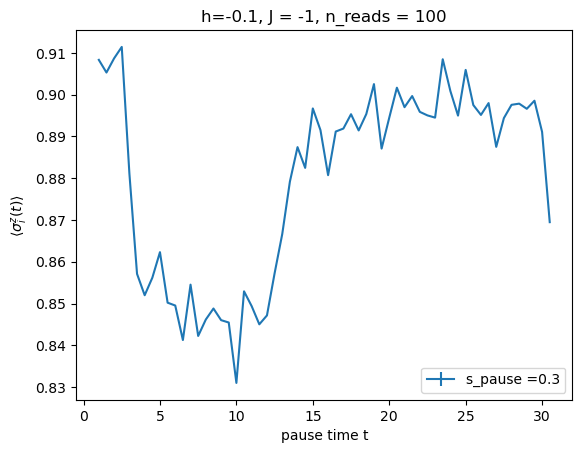

In [14]:

fig = plt.figure()
x = pause_list[:60]
y = mag_vals[:60]
yerr = 0*mag_errs[:60]

plt.errorbar(x, y, yerr=yerr, label='s_pause ={}'.format(sval))
plt.title('h={}, J = {}, n_reads = {}'.format(hval, jval, num_reads))
plt.ylabel(r"$\langle \sigma^z_i (t) \rangle$")
plt.xlabel("pause time t")
plt.legend(loc='lower right')
#plt.ylim([0.99, 1.01])

#note - BIIIIG error bars!

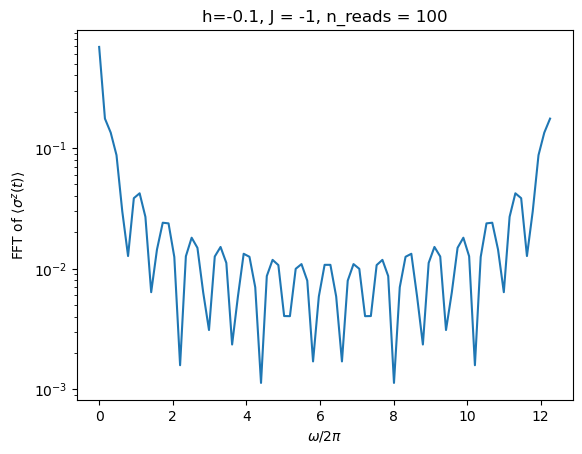

In [17]:
fftvals = np.abs(np.fft.fft(mag_vals, norm='forward'))
y = fftvals
x = np.arange(0, len(mag_vals), 1)*2*np.pi/pause_list[-1]
plt.plot(x, y, label='s_pause ={}'.format(sval))
plt.title('h={}, J = {}, n_reads = {}'.format(hval, jval, num_reads))
plt.yscale('log')
plt.ylabel(r"FFT of $\langle  \sigma^z (t)\rangle$")
plt.xlabel(r"$\omega/2\pi$");
#plt.xlim((0,6))

# Measure in the X and Y basis

Of course we measure the Z basis, but we can post-process it to "measure" in X and Y. See Chris' note. Works for small chains ($N < 20$). Need to decompose results array into 300 arrays of results for a given chain. It is highly possible that we can only observe the oscillations in the $X$ or $Y$ basis.

See Notebook!, can use qutip to get a tensor product for the $Z \times I \times I ...$ operators that are then sandwiched between $|\Psi>_z$. 

For this, you need the raw data-file, no spin-reversal transformation, and then extract the 12-bit strings one by one in a different file. Then, run anoter program to extract a dict of how often some specific bitstrings (for $N=12$, there are $2^{12}$ of them) appear.